In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 185MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 a


Training convnext_tiny...
Epoch 0/24
----------
train Loss: 0.8203 Acc: 0.7221
val Loss: 0.3996 Acc: 0.8754

Epoch 1/24
----------
train Loss: 0.3836 Acc: 0.8657
val Loss: 0.3475 Acc: 0.8789

Epoch 2/24
----------
train Loss: 0.3285 Acc: 0.8872
val Loss: 0.2634 Acc: 0.8982

Epoch 3/24
----------
train Loss: 0.2776 Acc: 0.9069
val Loss: 0.3772 Acc: 0.8491

Epoch 4/24
----------
train Loss: 0.2912 Acc: 0.8907
val Loss: 0.2888 Acc: 0.8842

Epoch 5/24
----------
train Loss: 0.2486 Acc: 0.9157
val Loss: 0.2473 Acc: 0.9211

Epoch 6/24
----------
train Loss: 0.2387 Acc: 0.9192
val Loss: 0.1911 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2211 Acc: 0.9205
val Loss: 0.1932 Acc: 0.9246

Epoch 8/24
----------
train Loss: 0.2175 Acc: 0.9205
val Loss: 0.3048 Acc: 0.8912

Epoch 9/24
----------
train Loss: 0.2129 Acc: 0.9219
val Loss: 0.2572 Acc: 0.9211

Epoch 10/24
----------
train Loss: 0.1906 Acc: 0.9337
val Loss: 0.2116 Acc: 0.9211

Epoch 11/24
----------
train Loss: 0.1812 Acc: 0.9346
val L

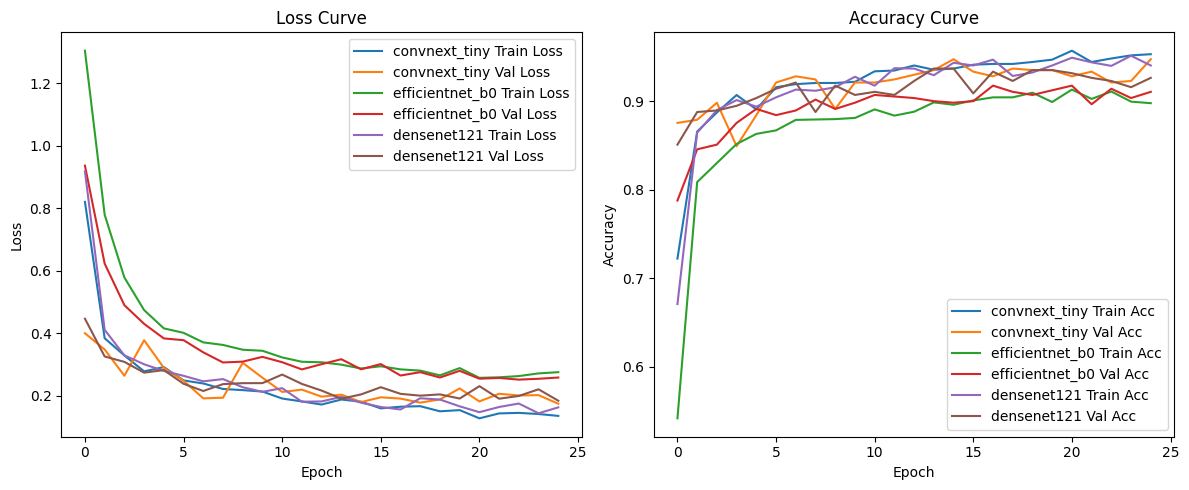

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, swin_t, convnext_tiny, efficientnet_b0, densenet121

# 设置数据目录
data_dir = '/kaggle/input/flower/flower_dataset'

# 数据增强和归一化
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 加载完整数据集
full_dataset = datasets.ImageFolder(data_dir, data_transforms)

# 划分训练集和验证集
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

# 定义训练函数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='model'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 每个epoch有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为评估模式

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零参数梯度
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 记录损失和准确率
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            # 深拷贝模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # 保存最佳模型
                save_dir = 'Ex2/work_dir'
                os.makedirs(save_dir, exist_ok=True)
                torch.save(model.state_dict(), os.path.join(save_dir, f'best_model_{model_name}.pth'))

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# 可视化损失和准确率曲线
def plot_metrics(metrics_dict):
    plt.figure(figsize=(12, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    for model_name, metrics in metrics_dict.items():
        plt.plot(metrics['train_losses'], label=f'{model_name} Train Loss')
        plt.plot(metrics['val_losses'], label=f'{model_name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    for model_name, metrics in metrics_dict.items():
        plt.plot(metrics['train_accuracies'], label=f'{model_name} Train Acc')
        plt.plot(metrics['val_accuracies'], label=f'{model_name} Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()
if __name__ == '__main__':
    

    model_configs = {
        'convnext_tiny': convnext_tiny(pretrained=True),
        'efficientnet_b0': efficientnet_b0(pretrained=True),
        'densenet121': densenet121(pretrained=True),
    }

    loss_dict = {}

    for model_name, model in model_configs.items():
        print(f"\nTraining {model_name}...")
        # 替换最后一层分类器
        if hasattr(model, 'fc'):
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, len(class_names))
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                in_ftrs = model.classifier[-1].in_features
                model.classifier[-1] = nn.Linear(in_ftrs, len(class_names))
            else:
                in_ftrs = model.classifier.in_features
                model.classifier = nn.Linear(in_ftrs, len(class_names))
        elif hasattr(model, 'heads'):
            # 针对vit_b_16模型的处理
            in_ftrs = model.heads.head.in_features
            model.heads.head = nn.Linear(in_ftrs, len(class_names))
        elif hasattr(model, 'head'):
            # 针对swin_t模型的处理
            in_ftrs = model.head.in_features
            model.head = nn.Linear(in_ftrs, len(class_names))
        else:
            raise ValueError(f"Unknown model head structure for {model_name}")

        model = model.to("cuda" if torch.cuda.is_available() else "cpu")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

        # 训练模型
        model, train_losses, val_losses, train_accs, val_accs = train_model(
            model, criterion, optimizer, scheduler, num_epochs=25, model_name=model_name
        )

        loss_dict[model_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': [acc.item() for acc in train_accs],
            'val_accuracies': [acc.item() for acc in val_accs]
        }

    # 绘图展示
    plot_metrics(loss_dict)
